In [1]:
# -----------------------------
# KEEP COLAB SESSION ALIVE
# -----------------------------
import IPython
from google.colab import output

# JavaScript to auto-click "connect" button every 60s to avoid idle disconnect
js = """
function ClickConnect(){
    console.log("Clicking reconnect button to prevent idle timeout");
    document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect, 1200000);
"""
display(IPython.display.Javascript(js))

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import copy
from typing import List, Dict, Any, Tuple, Optional
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
import time
import math
from functools import wraps
import os
from google.colab import drive
import io
import contextlib
import rich

In [3]:

# -----------------------------
# ViT Architecture (from grid_vit_cifar10.py)
# -----------------------------

class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor

class MLP(nn.Module):
    def __init__(self, dim, mlp_ratio=4, drop=0.0):
        super().__init__()
        hidden = int(dim * mlp_ratio)
        self.fc1 = nn.Linear(dim, hidden)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden, dim)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=6, qkv_bias=True, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)  # B, N, 3C
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # each: B, heads, N, head_dim

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        out = attn @ v  # B, heads, N, head_dim
        out = out.transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        out = self.proj_drop(out)
        return out

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio, drop=0.0, attn_drop=0.0, drop_path=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_ratio=mlp_ratio, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=384):
        super().__init__()
        assert img_size % patch_size == 0
        self.grid = img_size // patch_size  # 8
        self.num_patches = self.grid * self.grid  # 64
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # B, C, 8, 8
        x = x.flatten(2).transpose(1, 2)  # B, 64, C
        return x

class ViTSmallCIFAR(nn.Module):
    def __init__(self, num_classes=10, img_size=32, patch_size=4,
                 embed_dim=384, depth=12, num_heads=6, mlp_ratio=4.0,
                 drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0,
                 cls_norm=True):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, 3, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth decay rule
        dpr = torch.linspace(0, drop_path_rate, steps=depth).tolist()

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio,
                  drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i])
            for i in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.cls_norm = cls_norm
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # B, 64, C
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)  # B, 65, C
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        if self.cls_norm:
            x = self.norm(x)
        cls_tok = x[:, 0]
        logits = self.head(cls_tok)
        return logits

# ---------------------------
# Warmup Cosine LR Scheduler
# ---------------------------

class WarmupCosineLR(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, total_steps, warmup_steps=0, min_lr=1e-5, last_epoch=-1):
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1
        lrs = []
        for base_lr in self.base_lrs:
            if step < self.warmup_steps:
                lr = base_lr * float(step) / float(max(1, self.warmup_steps))
            else:
                progress = (step - self.warmup_steps) / float(max(1, self.total_steps - self.warmup_steps))
                cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
                lr = self.min_lr + (base_lr - self.min_lr) * cosine
            lrs.append(lr)
        return lrs

# ---------------------------
# Timer Class
# ---------------------------

class PBTTimer:
    """Timer class for tracking PBT experiment timing"""
    def __init__(self):
        self.metrics = {
            'total_start': None,
            'total_end': None,
            'epoch_times': [],
            'member_times': [],  # [epoch][member]
            'update_times': [],
            'member_details': {},  # {member_id: [times]}
            'batch_size_history': []  # [epoch][member_batch_size]
        }

    def start_total(self):
        """Start overall timer"""
        self.metrics['total_start'] = time.time()

    def end_total(self):
        """End overall timer"""
        self.metrics['total_end'] = time.time()

    def get_total_time(self):
        """Get total runtime"""
        if self.metrics['total_start'] and self.metrics['total_end']:
            return self.metrics['total_end'] - self.metrics['total_start']
        return 0

    def start_epoch(self):
        """Start timing an epoch"""
        self.current_epoch_start = time.time()
        self.current_member_times = []
        self.current_batch_sizes = []

    def end_epoch(self):
        """End timing an epoch"""
        if hasattr(self, 'current_epoch_start'):
            epoch_time = time.time() - self.current_epoch_start
            self.metrics['epoch_times'].append(epoch_time)
            self.metrics['member_times'].append(self.current_member_times)
            self.metrics['batch_size_history'].append(self.current_batch_sizes)

    def time_member(self, member_id: int, batch_size: int = None):
        """Context manager for timing member training"""
        class MemberTimer:
            def __init__(self, timer, member_id, batch_size):
                self.timer = timer
                self.member_id = member_id
                self.batch_size = batch_size

            def __enter__(self):
                self.start = time.time()
                return self

            def __exit__(self, *args):
                elapsed = time.time() - self.start
                self.timer.current_member_times.append(elapsed)
                self.timer.current_batch_sizes.append(self.batch_size)

                # Track detailed member times
                if self.member_id not in self.timer.metrics['member_details']:
                    self.timer.metrics['member_details'][self.member_id] = []
                self.timer.metrics['member_details'][self.member_id].append(elapsed)

        return MemberTimer(self, member_id, batch_size)

    def time_update(self):
        """Context manager for timing population updates"""
        class UpdateTimer:
            def __init__(self, timer):
                self.timer = timer

            def __enter__(self):
                self.start = time.time()
                return self

            def __exit__(self, *args):
                elapsed = time.time() - self.start
                self.timer.metrics['update_times'].append(elapsed)

        return UpdateTimer(self)

    def print_report(self):
        """Print detailed timing report"""
        total = self.get_total_time()
        epoch_times = self.metrics['epoch_times']
        member_times = self.metrics['member_times']
        update_times = self.metrics['update_times']
        batch_history = self.metrics['batch_size_history']

        print(f"\n{'='*70}")
        print(f"{'PBT TIMING REPORT':^70}")
        print(f"{'='*70}")

        # Overall statistics
        print(f"\n{'Overall Statistics':<40} {'Value':<30}")
        print(f"{'-'*70}")
        print(f"{'Total runtime':<40} {total:.2f}s ({total/60:.2f} min)")
        print(f"{'Number of epochs':<40} {len(epoch_times)}")
        print(f"{'Number of population updates':<40} {len([t for t in update_times if t > 0])}")

        # Epoch timing
        avg_epoch = np.mean(epoch_times)
        std_epoch = np.std(epoch_times)
        print(f"\n{'Epoch Timing':<40} {'Value':<30}")
        print(f"{'-'*70}")
        print(f"{'Average epoch time':<40} {avg_epoch:.2f}s")
        print(f"{'Std epoch time':<40} {std_epoch:.2f}s")
        print(f"{'Min epoch time':<40} {min(epoch_times):.2f}s (epoch {np.argmin(epoch_times)+1})")
        print(f"{'Max epoch time':<40} {max(epoch_times):.2f}s (epoch {np.argmax(epoch_times)+1})")

        # Member training timing
        all_member_times = [t for epoch_times in member_times for t in epoch_times]
        avg_member_time = np.mean(all_member_times)
        total_training_time = sum(all_member_times)

        print(f"\n{'Member Training Timing':<40} {'Value':<30}")
        print(f"{'-'*70}")
        print(f"{'Average member time per epoch':<40} {avg_member_time:.2f}s")
        print(f"{'Total training time':<40} {total_training_time:.2f}s")
        print(f"{'Training efficiency':<40} {(total_training_time/total*100):.1f}%")

        # Population update timing
        non_zero_updates = [t for t in update_times if t > 0]
        if non_zero_updates:
            avg_update = np.mean(non_zero_updates)
            total_update = sum(update_times)

            print(f"\n{'Population Update Timing':<40} {'Value':<30}")
            print(f"{'-'*70}")
            print(f"{'Average update time':<40} {avg_update:.2f}s")
            print(f"{'Total update time':<40} {total_update:.2f}s")
            print(f"{'Update efficiency':<40} {(total_update/total*100):.1f}%")

        # Batch size correlation
        if batch_history and len(batch_history[0]) > 0:
            batch_times = []
            for epoch_idx, batch_sizes in enumerate(batch_history):
                for member_idx, bs in enumerate(batch_sizes):
                    batch_times.append((bs, member_times[epoch_idx][member_idx]))

            # Group by batch size
            batch_stats = {}
            for bs, t in batch_times:
                if bs not in batch_stats:
                    batch_stats[bs] = []
                batch_stats[bs].append(t)

            print(f"\n{'Batch Size Analysis':<40} {'Avg Time':<15} {'Samples':<15}")
            print(f"{'='*70}")
            for bs in sorted(batch_stats.keys()):
                avg_time = np.mean(batch_stats[bs])
                samples = len(batch_stats[bs])
                print(f"{f'Batch size {bs}':<40} {avg_time:.2f}s{'':<5} {samples:<15}")

        # Per-member statistics
        print(f"\n{'Per-Member Statistics':<40} {'Avg Time':<15} {'Total Time':<15}")
        print(f"{'='*70}")
        for member_id in sorted(self.metrics['member_details'].keys()):
            times = self.metrics['member_details'][member_id]
            avg_time = np.mean(times)
            total_time = sum(times)
            print(f"{f'Member {member_id}':<40} {avg_time:.2f}s{'':<5} {total_time:.2f}s")

        print(f"\n{'='*70}")

# ---------------------------
# PBT Configuration
# ---------------------------

@dataclass
class PBTConfig:
    # Population settings
    population_size: int = 10  # Smaller for memory constraints
    exploit_interval: int = 5  # Exploit every 5 epochs
    truncation_factor: float = 0.25  # top 25% replace bottom 25%

    # ViT-specific hyperparameter search spaces
    lr_bounds: Tuple[float, float] = (1e-4, 1e-3)
    weight_decay_bounds: Tuple[float, float] = (0.02, 0.15)
    drop_path_bounds: Tuple[float, float] = (0.0, 0.2)
    warmup_epochs_bounds: Tuple[int, int] = (5, 5)
    batch_size_bounds: Tuple[int, int] = (256, 256)  # Batch size search space

    # Training settings
    epochs: int = 70  # Shorter run for demonstration
    min_lr: float = 1e-6

    # Model architecture (fixed for ViT-Small)
    embed_dim: int = 192
    depth: int = 12
    num_heads: int = 3
    mlp_ratio: float = 4.0
    patch_size: int = 8
    img_size: int = 32
    drive_base_path: str = '/content/drive/MyDrive/Colab_Checkpoints'
    seed: int = None
# ---------------------------
# PBT Member
# ---------------------------

class PBTMember:
    def __init__(self, model_class, model_args, hyperparams: Dict[str, float], member_id: int,
                 total_epochs: int, min_lr: float = 1e-6):
        self.member_id = member_id
        self.hyperparams = hyperparams
        self.total_epochs = total_epochs
        self.batch_size = hyperparams['batch_size']  # Get batch size from hyperparams
        self.min_lr = min_lr

        # NEW: Track LR history
        self.lr_history = []  # Store LR at each epoch
        self.current_lr = hyperparams['lr']  # Track current LR

        # Create ViT model with specific hyperparameters
        model_args['drop_path_rate'] = hyperparams['drop_path']
        self.model = model_class(**model_args)

        # AdamW optimizer for ViT
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
            betas=(0.9, 0.999),
            eps=1e-8
        )

        # Scheduler will be setup when dataloader is available
        self.scheduler = None

        # Tracking
        self.performance_history = []
        self.current_performance = 0.0
        self.steps = 0
        self.epoch = 0



    def setup_scheduler(self, train_loader_length: int, warmup_epochs: int):
        """Setup scheduler with correct total steps based on batch size"""
        total_steps = self.total_epochs * train_loader_length
        warmup_steps = warmup_epochs * train_loader_length
        self.scheduler = WarmupCosineLR(
            self.optimizer,
            total_steps=total_steps,
            warmup_steps=warmup_steps,
            min_lr=self.min_lr
        )

    def update_hyperparams(self, new_hyperparams: Dict[str, float]):
        """Update hyperparameters"""
        old_hyperparams = copy.deepcopy(self.hyperparams)
        self.hyperparams = new_hyperparams
        self.batch_size = new_hyperparams['batch_size']  # Update batch size
        self.current_lr = new_hyperparams['lr'] # Update current LR

        # Log LR change
        for key, val in old_hyperparams.items():
          if old_hyperparams[key] != new_hyperparams[key]:
            print(f"Member {self.member_id}: {key} changed from {val} to {new_hyperparams[key]}")


        # Update optimizer
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=new_hyperparams['lr'],
            weight_decay=new_hyperparams['weight_decay'],
            betas=(0.9, 0.999),
            eps=1e-8
        )

        # Reset scheduler (will be setup with new dataloader)
        self.scheduler = None


    def record_lr(self, epoch_lr: float = None):
      if epoch_lr is not None:
          self.lr_history.append(epoch_lr)
      else:
          # Get current LR from optimizer
          current_lr = self.optimizer.param_groups[0]['lr']
          self.lr_history.append(current_lr)
          self.current_lr = current_lr

    def update_weights(self, new_weights):
        self.model.load_state_dict(new_weights)

    def save_checkpoint(self):
        """Save model and optimizer state"""
        return {
            'model_state': copy.deepcopy(self.model.state_dict()),
            'optimizer_state': copy.deepcopy(self.optimizer.state_dict()),
            'scheduler_state': copy.deepcopy(self.scheduler.state_dict()) if self.scheduler else None,
            'hyperparams': copy.deepcopy(self.hyperparams),
            'performance': self.current_performance,
            'steps': self.steps,
            'epoch': self.epoch
        }

    def load_checkpoint(self, checkpoint):
        """Load model, optimizer, and scheduler state"""
        self.model.load_state_dict(checkpoint['model_state'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state'])
        if checkpoint['scheduler_state']:
            # Need to initialize scheduler before loading state_dict if it's not None
            # This assumes `setup_scheduler` would have been called before loading if it's not the first epoch
            if self.scheduler is None: # Placeholder if scheduler wasn't setup yet (e.g., loading into a fresh member obj)
                # This case is tricky, requires knowing train_loader_length etc.
                # For PBT, usually scheduler is reset/re-setup after hyperparam changes or init
                # For now, rely on `setup_scheduler` being called after `load_checkpoint` if needed.
                pass # Or raise an error/warning
            else:
                self.scheduler.load_state_dict(checkpoint['scheduler_state'])

        self.hyperparams = checkpoint['hyperparams']
        self.batch_size = checkpoint['hyperparams']['batch_size']
        self.current_performance = checkpoint['performance']
        self.steps = checkpoint['steps']
        self.epoch = checkpoint['epoch']

# ---------------------------
# Google Drive Checkpointing Helpers
# ---------------------------

def mount_drive_if_not_mounted():
    """Mounts Google Drive if it's not already mounted."""
    if not os.path.exists('/content/drive'):
        print("Google Drive not mounted. Mounting now...")
        drive.mount('/content/drive')
    else:
        print("Google Drive already mounted.")

def save_member_checkpoint_to_drive(member: PBTMember, drive_base_path: str, seed):
    """
    Saves a member's checkpoint to Google Drive with specified filename format, overwriting if exists.

    Args:
        member (PBTMember): The PBT member object.
        drive_base_path (str): The base path in Google Drive (e.g., '/content/drive/MyDrive/Colab_Checkpoints').
    """
    # Ensure Drive is mounted
    mount_drive_if_not_mounted()

    # Construct the target directory and ensure it exists
    # Filename format: model_{member_id}_seed_{member_id}.pt (member_id serves as 'seed' here)
    checkpoint_dir = os.path.join(drive_base_path, "pbt_checkpoints")
    os.makedirs(checkpoint_dir, exist_ok=True)

    checkpoint_filename = os.path.join(checkpoint_dir, f"model_{member.member_id}_seed_{seed}.pt")

    checkpoint_data = {
        'model_state': member.model.state_dict(),
        'optimizer_state': member.optimizer.state_dict(),
        'scheduler_state': member.scheduler.state_dict() if member.scheduler else None,
        'hyperparams': member.hyperparams,
        'performance': member.current_performance,
        'steps': member.steps,
        'epoch': member.epoch
    }

    torch.save(checkpoint_data, checkpoint_filename)
    print(f"Member {member.member_id}: Checkpoint saved to {checkpoint_filename}")


# ---------------------------
# Population Based Training
# ---------------------------

class PopulationBasedTraining:
    def __init__(self, config: PBTConfig, model_class, model_args):
        self.config = config
        self.model_class = model_class
        self.model_args = model_args
        self.population: List[PBTMember] = []
        self.best_performance = 0.0
        self.best_member = None

    def initialize_population(self):
        """Initialize population with random hyperparameters including batch size"""
        for i in range(self.config.population_size):
            hyperparams = {
                'lr': self._sample_log_uniform(*self.config.lr_bounds),
                'weight_decay': random.uniform(*self.config.weight_decay_bounds),
                'drop_path': random.uniform(*self.config.drop_path_bounds),
                'warmup_epochs': random.randint(*self.config.warmup_epochs_bounds),
                'batch_size': self._sample_batch_size()
            }

            member = PBTMember(
                model_class=self.model_class,
                model_args=self.model_args,
                hyperparams=hyperparams,
                member_id=i,
                total_epochs=self.config.epochs,
                min_lr=self.config.min_lr
            )
            self.population.append(member)

    def _sample_log_uniform(self, low, high):
        """Sample from log-uniform distribution"""
        return np.exp(random.uniform(np.log(low), np.log(high)))

    def _sample_batch_size(self):
        """Sample batch size from discrete options within bounds"""
        batch_options = [64, 128, 256, 512]
        valid_options = [bs for bs in batch_options
                        if self.config.batch_size_bounds[0] <= bs <= self.config.batch_size_bounds[1]]
        return random.choice(valid_options)

    def _perturb_hyperparam(self, value, bounds, is_log=True):
        """Perturb hyperparameter with random noise"""
        if is_log:
            low, high = np.log(bounds[0]), np.log(bounds[1])
            current = np.log(value)
        else:
            low, high = bounds
            current = value

        # Random walk with reflection at boundaries
        perturbed = current + random.uniform(-0.2, 0.2) * (high - low)
        perturbed = max(min(perturbed, high), low)  # Clip to bounds

        return np.exp(perturbed) if is_log else perturbed

    def _perturb_batch_size(self, current_batch_size):
        """Perturb batch size within discrete options"""
        batch_options = [64, 128, 256, 512]
        # Filter options within bounds
        valid_options = [bs for bs in batch_options
                        if self.config.batch_size_bounds[0] <= bs <= self.config.batch_size_bounds[1]]

        if current_batch_size not in valid_options:
            return random.choice(valid_options)

        current_idx = valid_options.index(current_batch_size)
        # Move up or down by 1 step (or stay same)
        new_idx = current_idx + random.choice([-1, 0, 1])
        new_idx = max(0, min(new_idx, len(valid_options) - 1))

        return valid_options[new_idx]

    def exploit_and_explore(self):
        """PBT core algorithm for ViT"""
        # Rank population by performance
        ranked_members = sorted(self.population,
                              key=lambda x: x.current_performance,
                              reverse=True)

        num_truncate = int(self.config.truncation_factor * self.config.population_size)
        top_members = ranked_members[:num_truncate]
        bottom_members = ranked_members[-num_truncate:]

        print(f"\n=== PBT Exploit & Explore ===")
        print(f"Top performers: {[m.current_performance for m in top_members]}")
        print(f"Bottom performers: {[m.current_performance for m in bottom_members]}")

        # Exploit: Copy from top to bottom
        for bottom_member in bottom_members:
            # Randomly select a top member to copy from
            donor = random.choice(top_members)
            better_weights = donor.model.state_dict()
            bottom_member.update_weights(better_weights)
            print(f"Member {bottom_member.member_id} copied from {donor.member_id}")
            # Explore: Perturb hyperparameters
            new_hyperparams = {
                'lr': self._perturb_hyperparam(
                    bottom_member.hyperparams['lr'],
                    self.config.lr_bounds,
                    is_log=True
                ),
                'weight_decay': self._perturb_hyperparam(
                    bottom_member.hyperparams['weight_decay'],
                    self.config.weight_decay_bounds,
                    is_log=False
                ),
                'drop_path': self._perturb_hyperparam(
                    bottom_member.hyperparams['drop_path'],
                    self.config.drop_path_bounds,
                    is_log=False
                ),
                'warmup_epochs': int(np.clip(
                    bottom_member.hyperparams['warmup_epochs'] + random.randint(-2, 2),
                    self.config.warmup_epochs_bounds[0],
                    self.config.warmup_epochs_bounds[1]
                )),
                'batch_size': self._perturb_batch_size(bottom_member.hyperparams['batch_size'])
            }

            bottom_member.update_hyperparams(new_hyperparams)

            print(f"Member {bottom_member.member_id} copied from {donor.member_id}")
            print(f"  LR={new_hyperparams['lr']:.2e}, WD={new_hyperparams['weight_decay']:.3f}, "
                  f"DropPath={new_hyperparams['drop_path']:.3f}, "
                  f"Warmup={new_hyperparams['warmup_epochs']} epochs, "
                  f"Batch={new_hyperparams['batch_size']}")

    def train_member_one_epoch(self, member: PBTMember, train_loader, device, scaler):
        """Train one ViT member for one epoch with mixed precision"""
        start = time.time()
        member.model.train()
        member.model.to(device)

        criterion = nn.CrossEntropyLoss()
        total_loss = 0.0
        correct = 0
        total = 0

        # Store LR at the start of epoch
        start_lr = member.optimizer.param_groups[0]['lr']



        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            member.optimizer.zero_grad(set_to_none=True)

            # Mixed precision training
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                output = member.model(data)
                loss = criterion(output, target)

            scaler.scale(loss).backward()
            scaler.step(member.optimizer)
            scaler.update()

            # Update scheduler if available (changes LR!)
            if member.scheduler:
                member.scheduler.step()

            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            member.steps += 1

        accuracy = 100. * correct / total
        avg_loss = total_loss / len(train_loader)

        # Record LR at the end of epoch
        end_lr = member.optimizer.param_groups[0]['lr']
        member.lr_history.append(end_lr) # Store in history
        member.current_lr = end_lr # Update current LR

        # Track performance
        member.current_performance = accuracy
        member.performance_history.append(accuracy)
        member.epoch += 1

        # Print LR change if it occurred
        if abs(start_lr - end_lr) > 1e-10: # If LR changed during epoch
          print(f" LR changed during epoch: {start_lr:.2e} -> {end_lr:.2e}")
        print(f'total runtime to train this model was {time.time() - start} seconds')
        print(f'Hyperparameteres for model {member.member_id} at epoch {member.epoch}')
        for key, val in member.hyperparams.items():
          print(f'{key}: {val} \n')
        print(f'_______ end of hyperparam printing _____')
        return avg_loss, accuracy

    def evaluate_member(self, member: PBTMember, test_loader, device):
        """Evaluate ViT member on test set"""
        member.model.eval()
        member.model.to(device)

        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = member.model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)

        accuracy = 100. * correct / total
        member.current_performance = accuracy
        return accuracy

    def get_population_stats(self):
        """Get statistics about current population"""
        performances = [m.current_performance for m in self.population]
        lrs = [m.hyperparams['lr'] for m in self.population]
        wds = [m.hyperparams['weight_decay'] for m in self.population]
        drop_paths = [m.hyperparams['drop_path'] for m in self.population]
        warmups = [m.hyperparams['warmup_epochs'] for m in self.population]
        batch_sizes = [m.hyperparams['batch_size'] for m in self.population]

        return {
            'mean_performance': np.mean(performances),
            'std_performance': np.std(performances),
            'best_performance': np.max(performances),
            'mean_lr': np.mean(lrs),
            'mean_weight_decay': np.mean(wds),
            'mean_drop_path': np.mean(drop_paths),
            'mean_warmup': np.mean(warmups),
            'mean_batch_size': np.mean(batch_sizes),
            'batch_sizes': batch_sizes
        }

# ---------------------------
# Data Loading
# ---------------------------

def build_dataloaders(batch_size: int, num_workers: int = 4):
    """Build CIFAR-10 dataloaders"""
    train_tf = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                           std=(0.2470, 0.2435, 0.2616)),
    ])
    test_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                           std=(0.2470, 0.2435, 0.2616)),
    ])

    train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, transform=train_tf, download=True)
    test_ds = torchvision.datasets.CIFAR10(root="./data", train=False, transform=test_tf, download=True)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                            num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=512, shuffle=False,
                           num_workers=num_workers, pin_memory=True)
    return train_loader, test_loader

In [4]:

# ---------------------------
# Main Experiment
# ---------------------------

def run_pbt_vit_experiment(seed):
    """Run PBT for ViT-Small on CIFAR-10 with comprehensive timing"""
    # Configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize timer
    timer = PBTTimer()
    timer.start_total()

    # PBT Configuration for ViT
    pbt_config = PBTConfig(
        population_size=10,
        exploit_interval=5,
        truncation_factor=0.25,
        #EPOCH CONFIGURATION
        epochs=70,  # Even shorter for quick testing        REDUCED THE EPOCHS TO 2 FROM ORIGINAL
        batch_size_bounds=(256, 256),
        seed = seed
        )

    random.seed(pbt_config.seed)

    # Mount Google Drive once at the beginning of the experiment
    mount_drive_if_not_mounted()

    # Initialize PBT for ViT
    pbt = PopulationBasedTraining(
        config=pbt_config,
        model_class=ViTSmallCIFAR,
        model_args={
            'num_classes': 10,            # CHANGED THIS FROM 5 TO 10 TO MATCH CIFAR-10
            'img_size': pbt_config.img_size,
            'patch_size': pbt_config.patch_size,
            'embed_dim': pbt_config.embed_dim,
            'depth': pbt_config.depth,
            'num_heads': pbt_config.num_heads,
            'mlp_ratio': pbt_config.mlp_ratio,
            'drop_rate': 0.0,
            'attn_drop_rate': 0.0,
            'cls_norm': True
        }
    )
    pbt.initialize_population()

    # Create gradient scaler for mixed precision
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    # Training loop
    history = []
    print("Starting PBT Training for ViT-Small...")
    print(f"Population size: {pbt_config.population_size}")
    print(f"Total epochs: {pbt_config.epochs}")
    print(f"Exploit interval: {pbt_config.exploit_interval} epochs")
    print(f"Checkpoints will be saved to: {pbt_config.drive_base_path}")

    for epoch in range(pbt_config.epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1}/{pbt_config.epochs}")
        print(f"{'='*60}")

        # Start timing this epoch
        timer.start_epoch()

        # Train all members
        for i, member in enumerate(pbt.population):
            print(f"\n--- Training Member {i} (Batch size: {member.batch_size}) ---")

            # Time member training
            with timer.time_member(member.member_id, member.batch_size):
                start_t = time.time()
                # Create dataloader for this member's batch size
                train_loader, test_loader = build_dataloaders(
                    batch_size=member.batch_size,
                    num_workers=2
                )

                # Setup scheduler if needed
                if member.scheduler is None:
                    member.setup_scheduler(
                        train_loader_length=len(train_loader),
                        warmup_epochs=member.hyperparams['warmup_epochs']
                    )
                print(f'built data in {time.time() - start_t} seconds')

                # Train member
                loss, train_acc = pbt.train_member_one_epoch(member, train_loader, device, scaler)

                # Evaluate this member
                start_t = time.time()
                test_acc = pbt.evaluate_member(member, test_loader, device)
                print(f'evaluation in {time.time() - start_t} seconds')

                print(f"  Loss: {loss:.4f}")
                print(f"  Train Accuracy: {train_acc:.2f}%")
                print(f"  Test Accuracy: {test_acc:.2f}%")

                # Save checkpoint to Google Drive after each epoch for each member
                save_member_checkpoint_to_drive(member, pbt_config.drive_base_path, pbt_config.seed)

        # PBT step: exploit and explore
        should_update = (epoch + 1) % pbt_config.exploit_interval == 0
        if should_update:
            print(f"\n--- Population Update (Epoch {epoch + 1}) ---")
            with timer.time_update():
                pbt.exploit_and_explore()
        else:
            # Record 0 update time for non-update epochs
            timer.metrics['update_times'].append(0.0)

        # End timing this epoch
        timer.end_epoch()

        # Record statistics
        stats = pbt.get_population_stats()
        history.append(stats)

        # Print epoch summary
        epoch_time = timer.metrics['epoch_times'][-1]
        avg_member_time = np.mean(timer.metrics['member_times'][-1])

        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1} Summary:")
        print(f"{'='*60}")
        print(f"Time: {epoch_time:.2f}s (Avg member: {avg_member_time:.2f}s)")
        print(f"Population Mean Accuracy: {stats['mean_performance']:.2f}%")
        print(f"Best Member Accuracy: {stats['best_performance']:.2f}%")
        print(f"Mean Batch Size: {stats['mean_batch_size']:.0f}")
        print(f"Mean Learning Rate: {stats['mean_lr']:.2e}")
        print(f"Mean Weight Decay: {stats['mean_weight_decay']:.3f}")

    # End overall timer
    timer.end_total()

    # Final results
    best_member = max(pbt.population, key=lambda x: x.current_performance)
    print(f"\n{'='*70}")
    print(f"{'PBT TRAINING COMPLETE':^70}")
    print(f"{'='*70}")
    print(f"Best member: {best_member.member_id}")
    print(f"Best accuracy: {best_member.current_performance:.2f}%")
    print(f"\nBest hyperparameters:")
    print(f"  Learning Rate: {best_member.hyperparams['lr']:.2e}")
    print(f"  Weight Decay: {best_member.hyperparams['weight_decay']:.3f}")
    print(f"  Drop Path Rate: {best_member.hyperparams['drop_path']:.3f}")
    print(f"  Warmup Epochs: {best_member.hyperparams['warmup_epochs']}")
    print(f"  Batch Size: {best_member.hyperparams['batch_size']}")

    # Print timing report
    timer.print_report()

    # Plot results
    plot_pbt_results_vit(history, pbt.population, timer)

    return pbt, history, timer

# ---------------------------
# Visualization
# ---------------------------

def plot_pbt_results_vit(history, population, timer):
    """Plot PBT training results with timing"""
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Plot 1: Population performance
    epochs = range(1, len(history) + 1)
    mean_perf = [h['mean_performance'] for h in history]
    best_perf = [h['best_performance'] for h in history]

    axes[0].plot(epochs, mean_perf, 'b-', label='Mean Population', linewidth=2)
    axes[0].plot(epochs, best_perf, 'r-', label='Best Population', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0].set_title('ViT Population Performance', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Individual member performance
    for member in population:
        axes[1].plot(range(1, len(member.performance_history) + 1),
                    member.performance_history,
                    linewidth=1.5,
                    alpha=0.7,
                    label=f'M{member.member_id} (BS={member.batch_size})')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Individual ViT Member Performance', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10, ncol=2)
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Learning rate evolution
    axes[2].clear()

    for i, member in enumerate(population):
        if len(member.lr_history) > 0:
          # Plot actual recorded LR history
          epochs_to_plot = range(1, len(member.lr_history) + 1)
          axes[2].semilogy(epochs_to_plot, member.lr_history,
                           linewidth=1.5, alpha=0.7,
                           label=f'Member {i} (BS={member.batch_size})',
                           marker='o', markersize=3)
        else:
          # Fallback: plot constant LR (shouldn't happen with tracking) THIS IS IN CASE THIS TRACKING FAILS
          epochs = range(1, len(member.performance_history) + 1)
          lrs = [member.hyperparams['lr']] * len(epochs)  # Simplified - LR changes per epoch
          axes[2].semilogy(epochs, lrs, linewidth=1.5, alpha=0.7, label=f'Member {i} (no history)')
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Learning Rate', fontsize=12)
    axes[2].set_title('Actual Learning Rate Evolution', fontsize=14, fontweight='bold')
    axes[2].legend(fontsize=10, ncol=2)
    axes[2].grid(True, alpha=0.3)



    # Add annotation for LR changes due to PBT
    pbt_update_epochs = []
    for epoch_idx, update_time in enumerate(timer.metrics['update_times']):
        if update_time > 0:  # PBT update occurred
            pbt_update_epochs.append(epoch_idx + 1)

    for update_epoch in pbt_update_epochs:
        axes[2].axvline(x=update_epoch, color='red', alpha=0.3, linestyle='--', linewidth=1)

    if pbt_update_epochs:
        axes[2].text(0.02, 0.98, 'Red dashes: PBT updates',
                    transform=axes[2].transAxes, fontsize=9,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))







    # Plot 4: Batch size evolution
    batch_history = timer.metrics['batch_size_history']
    for i in range(len(population)):
        batches = [epoch_batches[i] for epoch_batches in batch_history]
        axes[3].plot(epochs, batches, linewidth=2, marker='o', markersize=4, label=f'Member {i}')
    axes[3].set_xlabel('Epoch', fontsize=12)
    axes[3].set_ylabel('Batch Size', fontsize=12)
    axes[3].set_title('Batch Size Evolution', fontsize=14, fontweight='bold')
    axes[3].set_yticks([64, 128, 256])
    axes[3].legend(fontsize=10, ncol=2)
    axes[3].grid(True, alpha=0.3)

    # Plot 5: Epoch timing
    epoch_times = timer.metrics['epoch_times']
    axes[4].plot(epochs, epoch_times, 'g-', linewidth=2, marker='s', markersize=5)
    axes[4].set_xlabel('Epoch', fontsize=12)
    axes[4].set_ylabel('Time (seconds)', fontsize=12)
    axes[4].set_title('Epoch Duration', fontsize=14, fontweight='bold')
    axes[4].grid(True, alpha=0.3)
    axes[4].fill_between(epochs, 0, epoch_times, alpha=0.3, color='green')

    # Plot 6: Member training time distribution
    member_avg_times = []
    for member_id in sorted(timer.metrics['member_details'].keys()):
        avg_time = np.mean(timer.metrics['member_details'][member_id])
        member_avg_times.append(avg_time)

    bars = axes[5].bar(range(len(member_avg_times)), member_avg_times, color='skyblue')
    axes[5].set_xlabel('Member ID', fontsize=12)
    axes[5].set_ylabel('Average Training Time (seconds)', fontsize=12)
    axes[5].set_title('Average Training Time per Member', fontsize=14, fontweight='bold')
    axes[5].set_xticks(range(len(member_avg_times)))
    axes[5].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[5].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}s', ha='center', va='bottom', fontsize=9)

    # Plot 7: Batch size vs Training time
    batch_times = []
    for epoch_idx, batch_sizes in enumerate(timer.metrics['batch_size_history']):
        for member_idx, bs in enumerate(batch_sizes):
            batch_times.append((bs, timer.metrics['member_times'][epoch_idx][member_idx]))

    # Group by batch size
    batch_stats = {}
    for bs, t in batch_times:
        if bs not in batch_stats:
            batch_stats[bs] = []
        batch_stats[bs].append(t)

    batch_sizes_list = sorted(batch_stats.keys())
    avg_times = [np.mean(batch_stats[bs]) for bs in batch_sizes_list]

    bars2 = axes[6].bar(range(len(batch_sizes_list)), avg_times, color='lightcoral')
    axes[6].set_xlabel('Batch Size', fontsize=12)
    axes[6].set_ylabel('Average Training Time (seconds)', fontsize=12)
    axes[6].set_title('Batch Size vs Training Time', fontsize=14, fontweight='bold')
    axes[6].set_xticks(range(len(batch_sizes_list)))
    axes[6].set_xticklabels([str(bs) for bs in batch_sizes_list])
    axes[6].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        axes[6].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}s', ha='center', va='bottom', fontsize=9)

    # Plot 8: Runtime breakdown
    labels = ['Member Training', 'Population Updates', 'Other']
    training_total = sum([sum(t) for t in timer.metrics['member_times']])
    update_total = sum(timer.metrics['update_times'])
    other_total = timer.get_total_time() - training_total - update_total

    sizes = [training_total, update_total, other_total]
    colors = ['#ff9999', '#66b3ff', '#99ff99']

    axes[7].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                startangle=90, textprops={'fontsize': 10})
    axes[7].set_title('Runtime Breakdown', fontsize=14, fontweight='bold')

    # Plot 9: Final hyperparameter distribution
    final_lrs = [m.hyperparams['lr'] for m in population]
    final_batches = [m.hyperparams['batch_size'] for m in population]
    final_perf = [m.current_performance for m in population]

    scatter = axes[8].scatter(final_lrs, final_batches,
                             c=final_perf, cmap='viridis', s=200, alpha=0.8, edgecolors='k')
    axes[8].set_xscale('log')
    axes[8].set_xlabel('Learning Rate', fontsize=12)
    axes[8].set_ylabel('Batch Size', fontsize=12)
    axes[8].set_title('Final Hyperparameters vs Performance', fontsize=14, fontweight='bold')
    axes[8].set_yticks([64, 128, 256])
    plt.colorbar(scatter, ax=axes[8], label='Accuracy (%)')
    axes[8].grid(True, alpha=0.3)

    plt.suptitle('PBT for ViT-Small on CIFAR-10 with Timing Analysis',
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('pbt_vit_timing_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Also create a separate timing visualization
    plot_timing_details(timer)

def plot_timing_details(timer):
    """Create detailed timing visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: Cumulative time over epochs
    cumulative_time = np.cumsum(timer.metrics['epoch_times'])
    epochs = range(1, len(cumulative_time) + 1)

    axes[0, 0].plot(epochs, cumulative_time, 'b-', linewidth=2)
    axes[0, 0].fill_between(epochs, 0, cumulative_time, alpha=0.3)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Cumulative Time (seconds)', fontsize=12)
    axes[0, 0].set_title('Cumulative Runtime', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Member time progression
    for member_id in sorted(timer.metrics['member_details'].keys()):
        times = timer.metrics['member_details'][member_id]
        axes[0, 1].plot(range(1, len(times) + 1), times, linewidth=1.5,
                       label=f'Member {member_id}')
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Training Time (seconds)', fontsize=12)
    axes[0, 1].set_title('Member Training Time Progression', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=10, ncol=2)
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Batch size vs time scatter
    all_batch_times = []
    for epoch_idx, batch_sizes in enumerate(timer.metrics['batch_size_history']):
        for member_idx, bs in enumerate(batch_sizes):
            all_batch_times.append((bs, timer.metrics['member_times'][epoch_idx][member_idx]))

    batch_sizes_scatter = [bt[0] for bt in all_batch_times]
    times_scatter = [bt[1] for bt in all_batch_times]

    scatter = axes[1, 0].scatter(batch_sizes_scatter, times_scatter,
                                alpha=0.6, s=50, c='purple')
    axes[1, 0].set_xlabel('Batch Size', fontsize=12)
    axes[1, 0].set_ylabel('Training Time (seconds)', fontsize=12)
    axes[1, 0].set_title('Batch Size vs Training Time (All Samples)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xticks([64, 128, 256])
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Update time when it occurs
    update_epochs = [i+1 for i, t in enumerate(timer.metrics['update_times']) if t > 0]
    update_times_nonzero = [t for t in timer.metrics['update_times'] if t > 0]

    if update_times_nonzero:
        bars = axes[1, 1].bar(update_epochs, update_times_nonzero, color='orange', alpha=0.7)
        axes[1, 1].set_xlabel('Epoch', fontsize=12)
        axes[1, 1].set_ylabel('Update Time (seconds)', fontsize=12)
        axes[1, 1].set_title('Population Update Times', fontsize=14, fontweight='bold')
        axes[1, 1].set_xticks(update_epochs)
        axes[1, 1].grid(True, alpha=0.3, axis='y')

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.2f}s', ha='center', va='bottom', fontsize=9)
    else:
        axes[1, 1].text(0.5, 0.5, 'No population updates occurred',
                       ha='center', va='center', fontsize=12, transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Population Update Times', fontsize=14, fontweight='bold')

    plt.suptitle('Detailed Timing Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('pbt_detailed_timing.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_detailed_lr_evolution(population, timer, history):
    """Create detailed LR evolution plot showing all changes"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Plot 1: Individual member LR evolution
    colors = plt.cm.Set3(np.linspace(0, 1, len(population)))

    for i, member in enumerate(population):
        if len(member.lr_history) > 0:
            epochs = range(1, len(member.lr_history) + 1)

            # Plot line
            ax1.semilogy(epochs, member.lr_history,
                        color=colors[i], linewidth=2,
                        label=f'M{i} (BS={member.batch_size})',
                        alpha=0.8)

            # Mark PBT update points (where LR might jump)
            for epoch_idx, lr in enumerate(member.lr_history):
                if epoch_idx > 0 and member.lr_history[epoch_idx-1] != lr:
                    # Check if this was a PBT update epoch
                    if (epoch_idx + 1) in [ep+1 for ep, t in enumerate(timer.metrics['update_times']) if t > 0]:
                        ax1.plot(epoch_idx + 1, lr, 'r*', markersize=10, markeredgewidth=1, markeredgecolor='black')
                    else:
                        ax1.plot(epoch_idx + 1, lr, 'ko', markersize=5, alpha=0.5)

    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Learning Rate', fontsize=12)
    ax1.set_title('Detailed Learning Rate Evolution with Changes Marked',
                 fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10, ncol=2, loc='upper right')
    ax1.grid(True, alpha=0.3)

    # Add explanation
    ax1.text(0.02, 0.02, 'Red stars: PBT updates\nBlack dots: Cosine annealing',
            transform=ax1.transAxes, fontsize=10,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Plot 2: LR distribution over time (box plot per epoch)
    max_epochs = max([len(m.lr_history) for m in population if len(m.lr_history) > 0])

    if max_epochs > 0:
        # Collect LRs per epoch
        lrs_per_epoch = []
        for epoch in range(max_epochs):
            epoch_lrs = []
            for member in population:
                if len(member.lr_history) > epoch:
                    epoch_lrs.append(member.lr_history[epoch])
            lrs_per_epoch.append(epoch_lrs)

        # Create box plot
        positions = range(1, max_epochs + 1)
        box_data = [np.log10(np.array(epoch_lrs)) for epoch_lrs in lrs_per_epoch]

        bp = ax2.boxplot(box_data, positions=positions, widths=0.6,
                        patch_artist=True, showfliers=False)

        # Color boxes
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
            patch.set_alpha(0.7)

        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('log10(Learning Rate)', fontsize=12)
        ax2.set_title('Population Learning Rate Distribution Over Time',
                     fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)

        # Mark PBT update epochs
        for update_epoch in [ep+1 for ep, t in enumerate(timer.metrics['update_times']) if t > 0]:
            if update_epoch <= max_epochs:
                ax2.axvline(x=update_epoch, color='red', alpha=0.5,
                           linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.savefig('pbt_lr_evolution_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()

In [5]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
import sys
import io
import contextlib # Import contextlib

def save_text_to_pdf(text_content: str, file_path: str):
    """
    Saves given text content to a PDF file using ReportLab.

    Args:
        text_content (str): The text content to write to the PDF.
        file_path (str): The path where the PDF file will be saved.
    """
    # Create a PDF document
    c = canvas.Canvas(file_path, pagesize=A4)
    width, height = A4

    # Set font
    font_name = 'Helvetica'
    font_size = 10
    line_height = font_size + 2 # Add some padding
    c.setFont(font_name, font_size)

    # Margins
    left_margin = 50
    top_margin = height - 50
    current_y = top_margin

    # Split content into lines and draw
    lines = text_content.split('\n')
    for line in lines:
        if current_y < 50: # Check if new page is needed
            c.showPage()
            c.setFont(font_name, font_size)
            current_y = top_margin

        c.drawString(left_margin, current_y, line)
        current_y -= line_height

    # Save the PDF
    c.save()
    print(f"PDF successfully saved to: {file_path}")

print("Defined save_text_to_pdf function.")

Defined save_text_to_pdf function.


In [6]:
def one_seed_run(seed):
    # Initialize a StringIO buffer to capture all standard output and error
    output_buffer = io.StringIO()

    # Redirect sys.stdout and sys.stderr to the buffer
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):
        print("Starting PBT ViT Experiment with Timing...")
        print("Note: This will train ViT-Small models on CIFAR-10")
        print("Each member may have different batch sizes\n")

        # Define a seed for reproducibility and output file naming
        experiment_seed = seed
        output_filename_pdf = f"pbt_10_pops_ablation_experiment_output_seed_{experiment_seed}.pdf"

        # Mount Google Drive to ensure the output can be saved
        mount_drive_if_not_mounted()

        pbt, history, timer = run_pbt_vit_experiment(experiment_seed)

        # These final messages are part of the experiment log, so they should be in the PDF
        print(f"\nExperiment completed successfully!")
        print(f"Results saved to: pbt_vit_timing_results.png")
        print(f"Detailed timing saved to: pbt_detailed_timing.png")

    # After the experiment, the original stdout/stderr are restored.

    # Define the output file path in Google Drive
    pbt_config_instance = PBTConfig(seed=experiment_seed)
    output_dir = os.path.join(pbt_config_instance.drive_base_path, "pbt_checkpoints")
    os.makedirs(output_dir, exist_ok=True)
    output_filepath_pdf = os.path.join(output_dir, output_filename_pdf)

    # Save the captured output to a PDF file
    save_text_to_pdf(output_buffer.getvalue(), output_filepath_pdf)

    # This message should appear in Colab's standard output, not in the saved PDF file.
    print(f"Terminal output saved to: {output_filepath_pdf}")



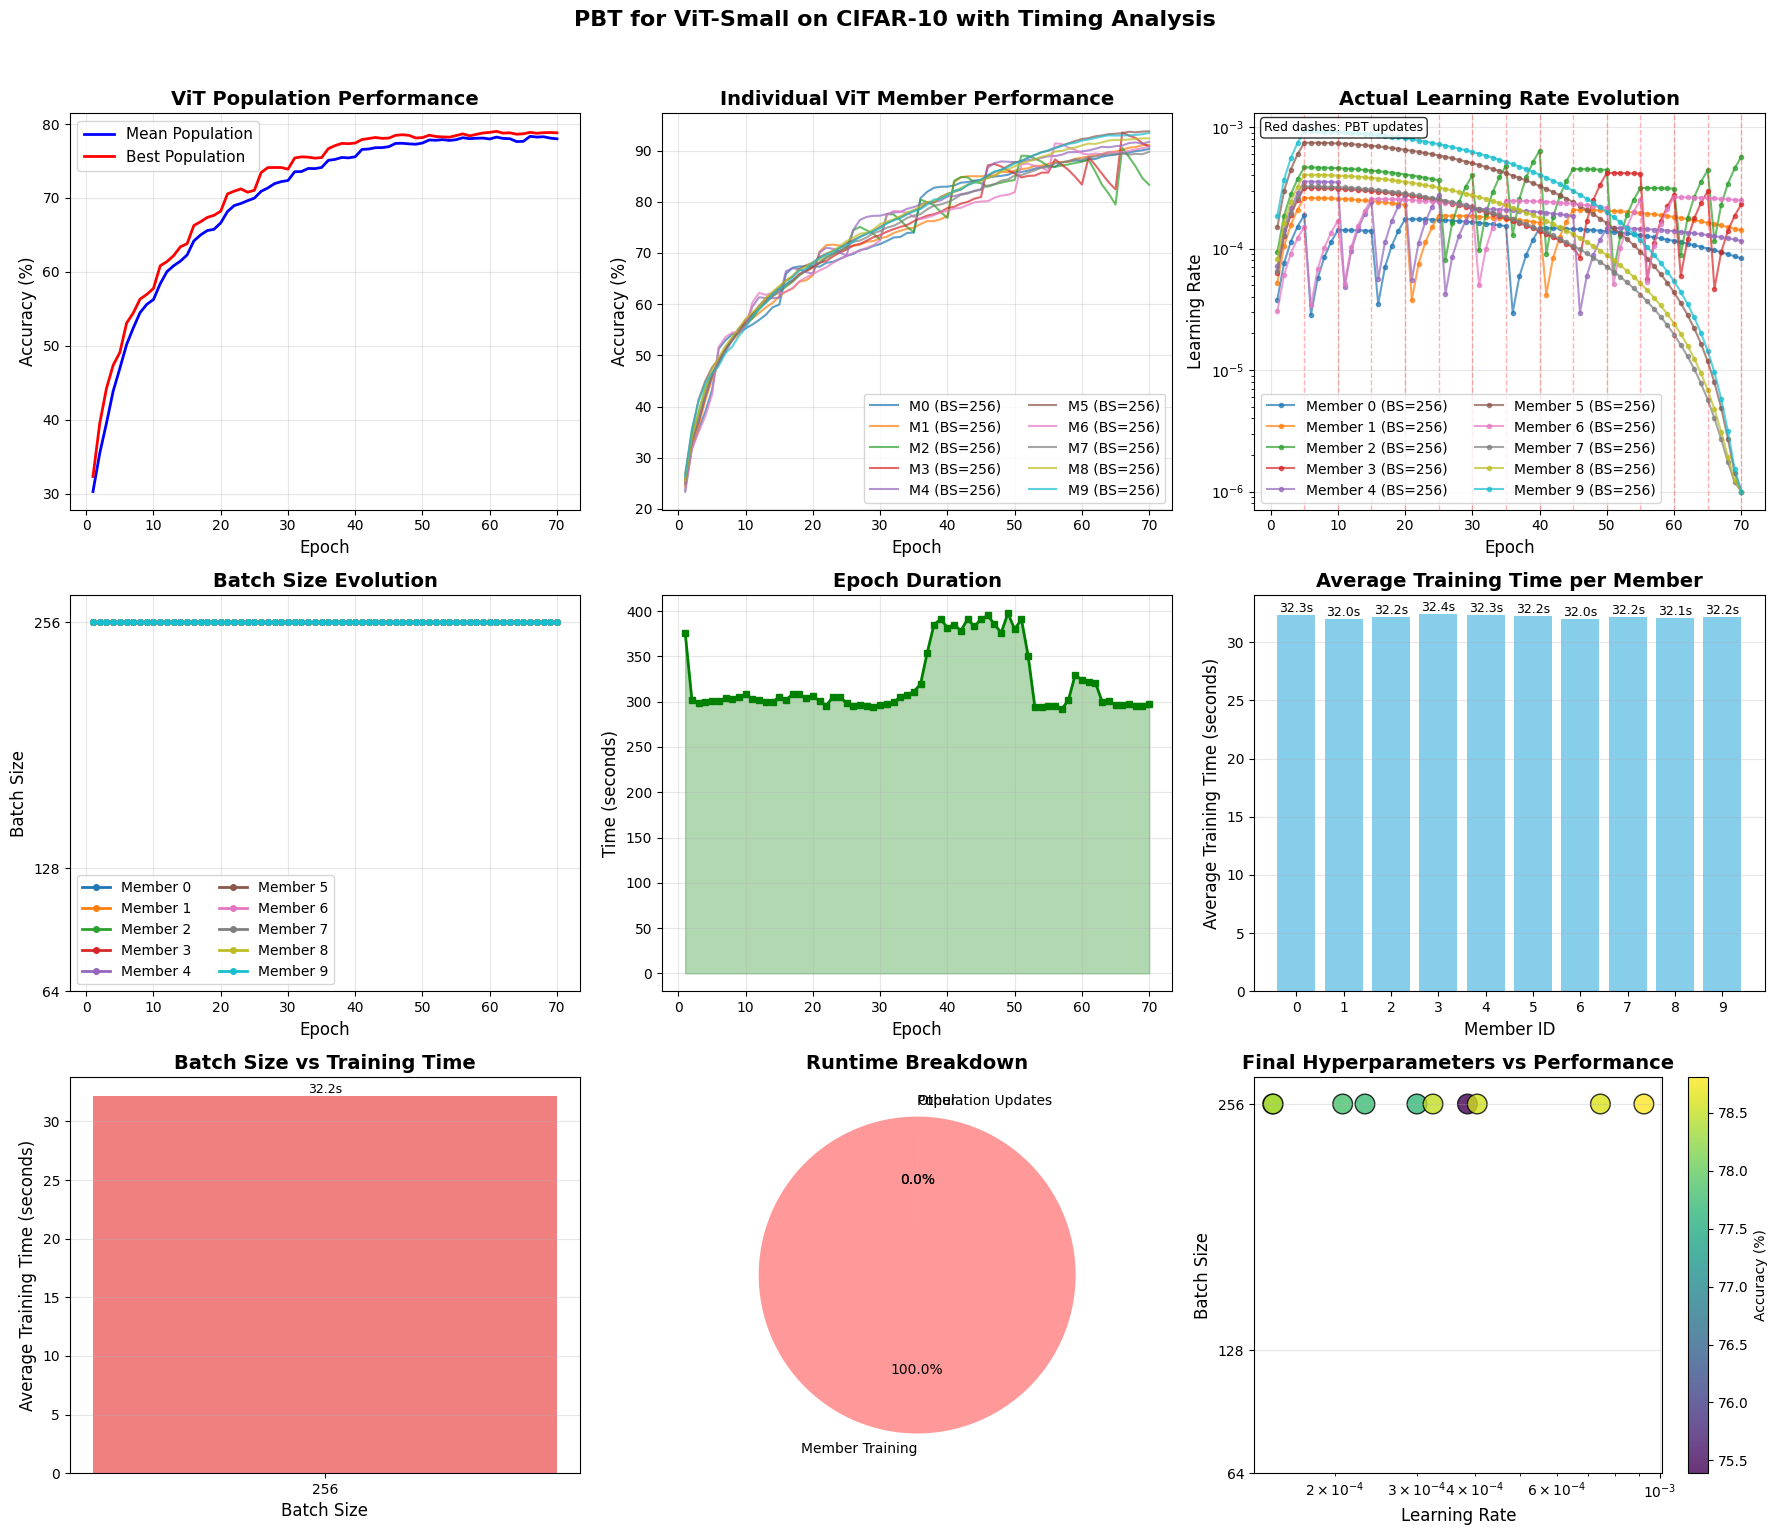

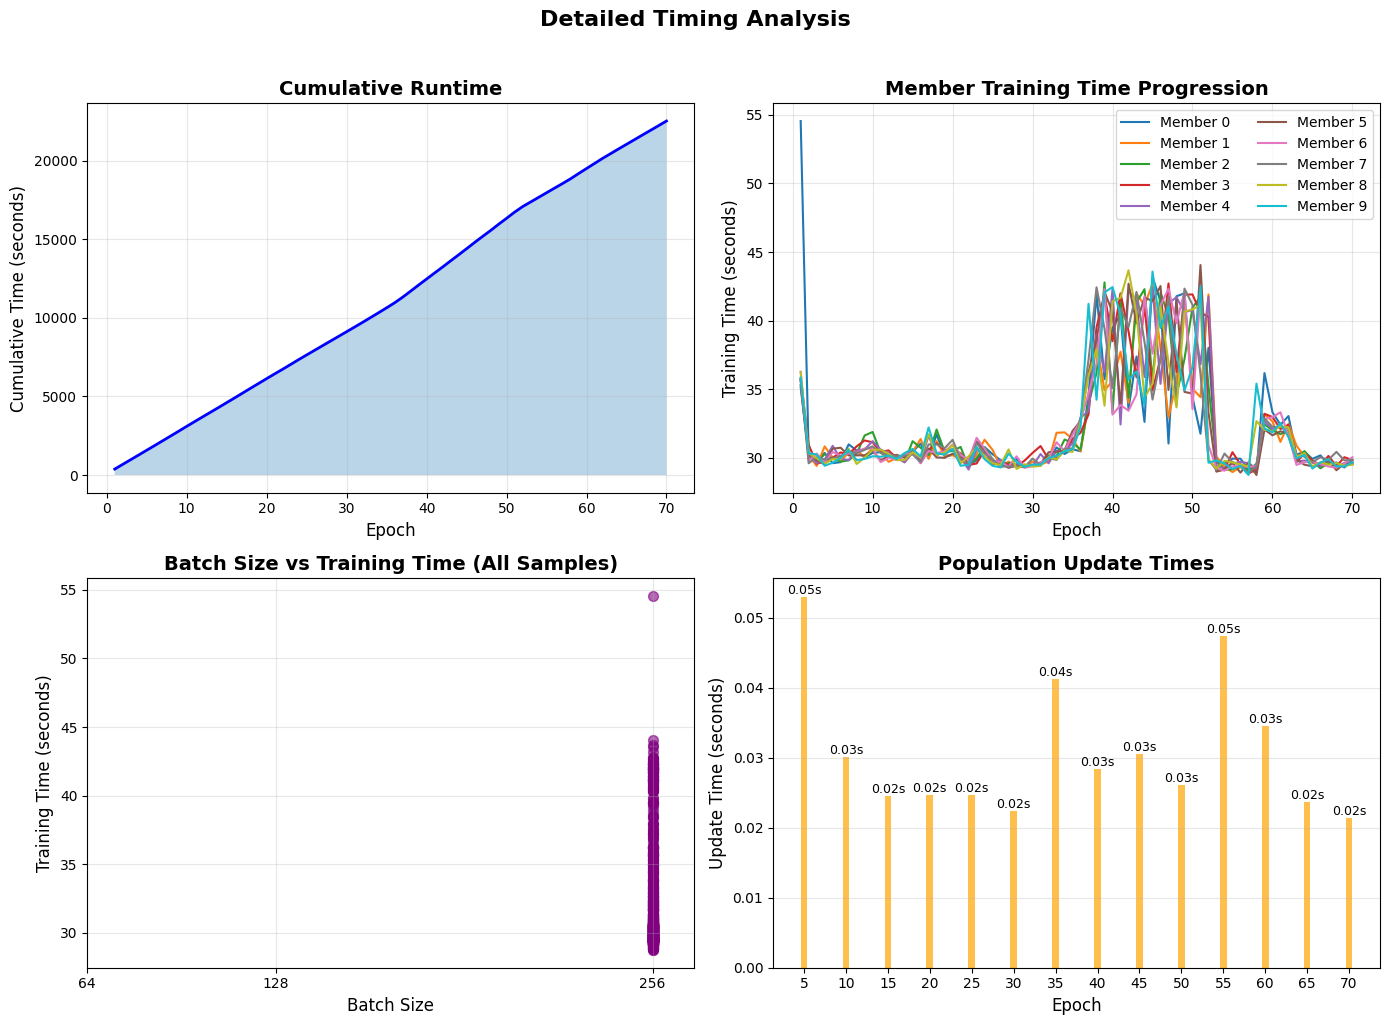

PDF successfully saved to: /content/drive/MyDrive/Colab_Checkpoints/pbt_checkpoints/pbt_10_pops_ablation_experiment_output_seed_38042.pdf
Terminal output saved to: /content/drive/MyDrive/Colab_Checkpoints/pbt_checkpoints/pbt_10_pops_ablation_experiment_output_seed_38042.pdf


KeyboardInterrupt: 

In [7]:
if __name__ == "__main__":
  for seed in [38042, 217401, 637451, 207796, 45921]:
    one_seed_run(seed)

## Final Task

### Subtask:
Confirm that the changes have been applied and explain how to view the generated PDF files.


## Summary:

### Q&A
*   **Confirm that the changes have been applied and explain how to view the generated PDF files.**
    Yes, the changes have been successfully applied. The `one_seed_run` function has been modified to capture standard output and errors, and then save this captured text into a PDF file in Google Drive using the newly defined `save_text_to_pdf` function. To view the generated PDF files, you would navigate to your mounted Google Drive, specifically within the `pbt_checkpoints` directory (e.g., `/{your_drive_mount_path}/pbt_checkpoints/`) which will contain files named like `pbt_experiment_output_seed_X.pdf`, where `X` is the seed used for the run.

### Data Analysis Key Findings
*   The `reportlab` library, specifically version `reportlab-4.4.5`, was successfully installed to enable PDF generation.
*   A helper function `save_text_to_pdf` was defined, capable of taking text content and a file path, then generating a multi-page PDF document with `Helvetica` font size 10, including logic for automatic page breaks when content exceeds page height.
*   The `one_seed_run` function was successfully refactored to replace `rich.Console` HTML output with PDF output. It now uses `contextlib.redirect_stdout` and `contextlib.redirect_stderr` to capture all console output into an in-memory buffer.
*   The captured output is then passed to the `save_text_to_pdf` function, saving the experiment logs as a PDF file within a dynamically created `pbt_checkpoints` directory in Google Drive.

### Insights or Next Steps
*   The implemented solution provides a robust way to persist detailed experiment logs in an easily shareable and readable PDF format directly within Google Drive, which is beneficial for documentation and reproducibility.
*   The next step is to execute the `one_seed_run` function with various seeds to generate actual PDF files and visually confirm their content and accessibility within Google Drive.
